# ぷよぷよのフィールドを認識しよう

## 動作確認済み環境

- Windows10
- Anaconda3
- python3.7
- チュートリアル動かす以外にinstallしたモジュール(pillow, pandas) 
- current directoryに puyodataフォルダを追加  
　　　　　　　　　　　　　

## ぷよぷよフィールドのデータ
ぷよぷよの対戦動画からフレームを抽出
フレーム中の各ぷよマスを切り出し

データセットの中身は、

* x:ぷよ画像(15×15×RGB)
* y:正解ラベル（0:ぷよなし, 1:赤, 2:緑, 3:青, 4:黄, 5:紫, 6:お邪魔, 7:判別不能）

* trainデータ数が、各ラベル600枚の計4800枚
* testデータ数が、各ラベル100枚の計800枚

In [4]:
# puyo_load_data()の定義
# データセット読み込みインタフェース

# number⇒ぷよ色変換const変数
num2color = ['No', 'Red', 'Green', 'Blue', 'Yellow', 'Purple', 'Ojama', 'Unknown']

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def puyo_load_data():
    puyo_type = 8
    train_data_num = 600 * puyo_type
    test_data_num = 100 * puyo_type

    #返すデータ変数の生成
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    #正解ファイル読み込み
    train_csv = pd.read_csv(filepath_or_buffer='puyodata/train/train.csv', encoding="utf_8", sep=",")
    train_data = train_csv[['num', 'color']] 
    test_csv = pd.read_csv(filepath_or_buffer='puyodata/test/test.csv', encoding="utf_8", sep=",")
    test_data = test_csv[['num', 'color']] 


    #データの格納(入力データ読み込みと同時に行う)
    for i in range(train_data_num):
        img = Image.open("puyodata/train/img/" + str(i) + ".png")
        img = img.convert("RGB")
        x_train.append(np.array(img))    
        y_train.append(train_data['color'][i])

    for i in range(test_data_num):
        img = Image.open("puyodata/test/img/" + str(i) + ".png")
        img = img.convert("RGB")
        x_test.append(np.array(img))
        y_test.append(test_data['color'][i])
        
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return (x_train, y_train), (x_test, y_test)

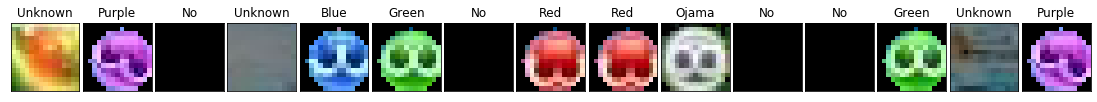

In [5]:
# データ読み込みと表示

%matplotlib inline
import matplotlib.pyplot as plt

# データの読み込み
(x_train, y_train), (x_test, y_test) = puyo_load_data()

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(15):
    ax = fig.add_subplot(1, 15, i + 1, xticks=[], yticks=[])
    ax.set_title(num2color[y_train[i]])
    ax.imshow(x_train[i])

In [6]:
# データの正規化
from tensorflow.keras.utils import to_categorical
# 入力画像を行列(15x15×3)からベクトル(長さ675)に変換
#x_train = x_train.reshape(-1, 675)
#x_test = x_test.reshape(-1, 675)

# 入力画像正規化
x_train = x_train.astype('float32')
x_train = x_train / 255.0
x_test = x_test.astype('float32')
x_test = x_test / 255.0

# 名義尺度の値をone-hot表現へ変換
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [23]:
# 上手くいかないモデル1

# https://qiita.com/neet-AI/items/2b3d7f743e4d6c6d8e10
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers.core import Dropout

# モデルの「容器」を作成
model = Sequential()

# 「容器」へ各layer（Dense, Activation）を積み重ねていく（追加した順に配置されるので注意）
# 最初のlayerはinput_shapeを指定して、入力するデータの次元を与える必要がある
model.add(Conv2D(20, 3, padding='same', input_shape=(15, 15, 3)))
model.add(Activation('relu'))
model.add(Conv2D(30, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(50, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(90))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(units=8))
model.add(Activation('softmax'))

# モデルの学習方法について指定しておく
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [24]:
model.fit(x_train, y_train,
          batch_size=400, epochs=10, verbose=1,
          validation_data=(x_test, y_test))

Train on 4800 samples, validate on 800 samples
Epoch 1/10
4800/4800 [==============================] - 4s 916us/step - loss: 12.2460 - acc: 0.2373 - val_loss: 12.3478 - val_acc: 0.2475
Epoch 2/10
4800/4800 [==============================] - 3s 711us/step - loss: 11.7072 - acc: 0.2667 - val_loss: 7.4985 - val_acc: 0.4075
Epoch 3/10
4800/4800 [==============================] - 3s 695us/step - loss: 8.7671 - acc: 0.3125 - val_loss: 1.9215 - val_acc: 0.4638
Epoch 4/10
4800/4800 [==============================] - 3s 685us/step - loss: 2.1432 - acc: 0.3360 - val_loss: 1.5093 - val_acc: 0.4937
Epoch 5/10
4800/4800 [==============================] - 3s 688us/step - loss: 1.8942 - acc: 0.3425 - val_loss: 1.7201 - val_acc: 0.4062
Epoch 6/10
4800/4800 [==============================] - 3s 680us/step - loss: 1.8242 - acc: 0.3500 - val_loss: 1.6669 - val_acc: 0.3975
Epoch 7/10
4800/4800 [==============================] - 3s 684us/step - loss: 1.7625 - acc: 0.3650 - val_loss: 1.6369 - val_acc: 0.410

In [7]:
# 上手くいく学習方法1

# https://newtechnologylifestyle.net/keras%E3%81%AEcnn%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%97%E3%81%A6%E3%82%AA%E3%83%AA%E3%82%B8%E3%83%8A%E3%83%AB%E7%94%BB%E5%83%8F%E3%81%A7%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98%E3%82%92%E8%A1%8C%E3%81%A3/

import keras 
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten

# CNNを構築
model = Sequential()
 
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Activation('softmax'))
 
# コンパイル
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])







Using TensorFlow backend.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [8]:
model.fit(x_train, y_train,
          batch_size=60, epochs=20, verbose=1,
          validation_data=(x_test, y_test))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4800 samples, validate on 800 samples
Epoch 1/20





4800/4800 [==============================] - 4s 798us/step - loss: 2.0470 - acc: 0.2252 - val_loss: 1.9997 - val_acc: 0.3650
Epoch 2/20
4800/4800 [==============================] - 3s 534us/step - loss: 1.9683 - acc: 0.2854 - val_loss: 1.8903 - val_acc: 0.3750
Epoch 3/20
4800/4800 [==============================] - 3s 554us/step - loss: 1.8452 - acc: 0.3585 - val_loss: 1.6321 - val_acc: 0.7337
Epoch 4/20
4800/4800 [==============================] - 2s 520us/step - loss: 1.4414 - acc: 0.5721 - val_loss: 0.9672 - val_acc: 0.8738
Epoch 5/20
4800/4800 [==============================] - 3s 575us/step - loss: 0.9280 - acc: 0.7525 - val_loss: 0.5369 - val_acc: 0.8763
Epoch 6/20
4800/4800 [==============================] - 3s 523us/step - loss: 0.6174 - acc: 0.8567 - val_loss: 0.4563 - val_acc: 0.8788
Epoch 7/20
4800/4800 [=============

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.035498385038226846
Test accuracy: 0.98375


[0. 0. 0. 0. 0. 1. 0. 0.]
[1.6155001e-09 1.5492150e-08 3.3511449e-14 6.5378175e-05 4.8682558e-11
 9.9986708e-01 6.0681527e-06 6.1482875e-05]
この画像は0.9998671の確率でPurple


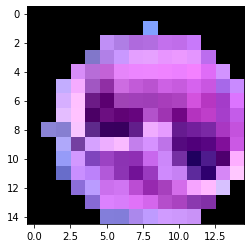

In [36]:
classes = model.predict(x_test, batch_size=10)

plt.imshow(x_test[3])
print(y_test[3])
print(classes[3])
print("この画像は" + str(max(classes[3])) + "の確率で" + num2color[np.argmax(classes[3])])


In [40]:
# モデルの保存
print('save the architecture of a model')
json_string = model.to_json()
open('./model/cnn_model.json', 'w').write(json_string)
yaml_string = model.to_yaml()
open('./model/cnn_model.yaml', 'w').write(yaml_string)
print('save weights')
model.save_weights('./model/cnn_model_weights.hdf5')



save the architecture of a model
save weights
